In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [11]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for learning_rate in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate, reg,
                              num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(learning_rate, reg)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

iteration 0 / 1500: loss 89.843343
iteration 100 / 1500: loss 88.239207
iteration 200 / 1500: loss 86.667298
iteration 300 / 1500: loss 85.130721
iteration 400 / 1500: loss 83.613732
iteration 500 / 1500: loss 82.141719
iteration 600 / 1500: loss 80.702093
iteration 700 / 1500: loss 79.296127
iteration 800 / 1500: loss 77.882495
iteration 900 / 1500: loss 76.500688
iteration 1000 / 1500: loss 75.179260
iteration 1100 / 1500: loss 73.866241
iteration 1200 / 1500: loss 72.595038
iteration 1300 / 1500: loss 71.316061
iteration 1400 / 1500: loss 70.097846
iteration 0 / 1500: loss 777.757739
iteration 100 / 1500: loss 638.337620
iteration 200 / 1500: loss 524.201837
iteration 300 / 1500: loss 430.774493
iteration 400 / 1500: loss 354.276393
iteration 500 / 1500: loss 291.666651
iteration 600 / 1500: loss 240.403076
iteration 700 / 1500: loss 198.437251
iteration 800 / 1500: loss 164.077472
iteration 900 / 1500: loss 135.958985
iteration 1000 / 1500: loss 112.934194
iteration 1100 / 1500: lo

In [12]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.429


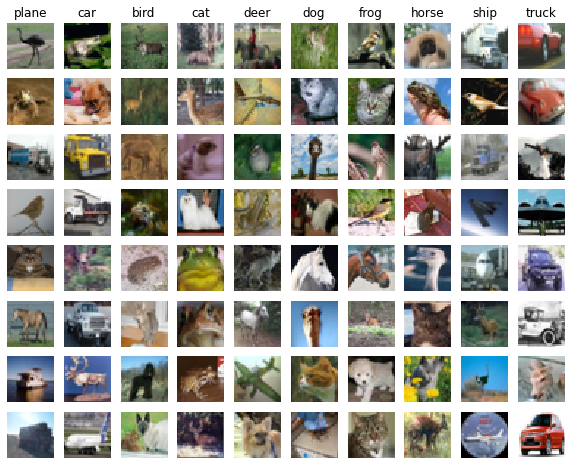

In [13]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$
For some classes they make sense. For instance, cats and dogs are animals that have similar appearance in the sense of edges, they both have four legs and one tail. Thus, images from these classes can be mixed up, we can also include here horses or deers. A similar example is the case of cars and trucks. The plane class is interesting because the misclassified examples have similarities in the sense of colors, thus they are commonly mixed up with ship images because the sky and sea colors are very similar. However, there are classes that do not make sense at all, it is the case of the bird class where images of dogs, cats, planes and others are misclassified. We can assume all these images where classified as bird because of the color features.

In conclusion, the combination of HOG and color histogram feature vectors are not enough to discriminate correctly all the classes. The HOG descriptor is very useful because it takes into account the edges, but we have to take into account different type of invariances that HOG might not consider, e.g., invariance to translation. Besides that, HOG has different parameters that we can cross-validate for a better performance. Color histogram features can help in some cases (similar colors) but are not very helpful for others. However, we can still consider this features but maybe with a lower importance when combining it with other features like HOG. Finally, we can use other type of descriptors to improve the accuracy of our model, e.g., SIFT, LBP (texture), etc.




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [17]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [35]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# data = {}
# data['X_train'] = X_train_feats
# data['y_train'] = y_train
# data['X_val'] = X_val_feats
# data['y_val'] = y_val
# data['X_test'] = X_test_feats
# data['y_test'] = y_test

# best_val_acc = 0.0
# best_hidden_size = 0

# hidden_sizes = [hidden_dim]
# learning_rates = [1e-4, 5e-4, 1e-3]
# num_epochs = [5, 10, 15]
# regs = [0.3, 0.5, 0.7]

# for hidden_size in hidden_sizes:
#     for learning_rate in learning_rates:
#         for num_epoch in num_epochs:
#             for reg in regs:
#                 net = TwoLayerNet(input_dim, hidden_size, num_classes, reg=reg)
  
#                 solver = Solver(net, data,
#                                 update_rule='sgd',
#                                 optim_config={
#                                 'learning_rate': learning_rate,
#                                 },
#                                 lr_decay=0.95,
#                                 num_epochs=num_epoch, batch_size=100,
#                                 print_every=300)
#                 solver.train()

#                 if solver.best_val_acc > best_val_acc:
#                     best_val_acc = solver.best_val_acc
#                     best_net = net
#                     best_solver = solver

# print("///////////////////////////////")
# print("Best validation accuracy:", best_val_acc)
# print("Best learning_rate:", best_solver.optim_config['learning_rate'])
# print("Best num_epochs:", best_solver.num_epochs)
# print("Best regularization strength:", best_net.reg)

best_val = 0.0

def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    lr = 10**np.random.uniform(lr_min, lr_max)
    reg = 10**np.random.uniform(reg_min, reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden

# Use of random search for hyperparameter search
for i in range(20):
    lr, reg, hidden_dim = generate_random_hyperparams(-1, 0, -7, -4, 10, 500)

    # Create a two-layer network
    net = TwoLayerNet(input_dim, hidden_dim, num_classes, reg=reg)
    
    # Train the network
    solver = Solver(net, data,
                    update_rule='sgd',
                    optim_config={
                    'learning_rate': lr,
                    },
                    lr_decay=0.95,
                    num_epochs=num_epoch, batch_size=100,
                    verbose=False)
    
    solver.train()

    # Predict on the training set
    train_accuracy = solver.train_acc

    # Save best values
    if solver.val_acc > best_val:
        best_val = solver.val_acc
        best_net = net
    
    # Print results
    print('lr %e reg %e hid %d  train accuracy: %f val accuracy: %f' % (
                lr, reg, hidden_dim, train_accuracy, solver.val_acc))
    
print('best validation accuracy achieved: %f' % best_val)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


lr 1.388314e-01 reg 9.421511e-06 hid 86  train accuracy: 0.659000 val accuracy: 0.563000
lr 2.262177e-01 reg 2.350212e-05 hid 40  train accuracy: 0.611000 val accuracy: 0.563000
lr 2.060231e-01 reg 8.094806e-05 hid 258  train accuracy: 0.705000 val accuracy: 0.583000
lr 2.451985e-01 reg 3.828192e-05 hid 472  train accuracy: 0.768000 val accuracy: 0.560000
lr 6.544059e-01 reg 1.084166e-07 hid 386  train accuracy: 0.761000 val accuracy: 0.549000
lr 5.959756e-01 reg 4.234090e-07 hid 49  train accuracy: 0.608000 val accuracy: 0.540000
lr 7.763579e-01 reg 5.479828e-07 hid 431  train accuracy: 0.800000 val accuracy: 0.558000
lr 2.046289e-01 reg 2.252016e-05 hid 330  train accuracy: 0.744000 val accuracy: 0.582000
lr 2.240616e-01 reg 1.497174e-05 hid 210  train accuracy: 0.718000 val accuracy: 0.577000
lr 2.420217e-01 reg 9.273726e-05 hid 92  train accuracy: 0.690000 val accuracy: 0.585000
lr 1.494324e-01 reg 6.760415e-05 hid 367  train accuracy: 0.707000 val accuracy: 0.602000
lr 1.089651e-0

In [36]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.575
